In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.distributions import Beta
import torch.distributions as dist
%matplotlib inline
import numpy as np
import pandas as pd
import sys
import os
import random
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import utils
import evaluate

In [2]:
def plot_tensors_as_images(images):
    fig, axs = plt.subplots(1, len(images), figsize=(15, 3))  # Create 1x5 grid of subplots
    for i in range(5):
        axs[i].imshow(images[i].cpu().detach().numpy(), cmap='Grays')  # Convert tensor to numpy for plotting
        axs[i].axis('off')  # Hide axes
    
    plt.show()

In [3]:
def save_checkpoint(model, checkpoint_filename: str):
    dirname = os.path.dirname(checkpoint_filename) or "."
    os.makedirs(dirname, exist_ok=True)
    torch.save({"model_state": model.state_dict()}, checkpoint_filename+".pt")
    print(f"\n*** Saved checkpoint {checkpoint_filename}")

In [4]:
def get_device():
    if torch.cuda.is_available(): 
     dev = "cuda:0" 
    else: 
     dev = "cpu" 
    return torch.device(dev) 

In [5]:
device = get_device()
print(device)
torch.autograd.set_detect_anomaly(True)

cpu


In [6]:
def ELBO_loss(recon_x, x, mu, sigma, beta=1, b1 = 255, a1 = 0, distr='normal'):
    reconstruction_loss = torch.nn.functional.mse_loss(recon_x, x, reduction='mean')
    #recon_error = evaluate.reconstruction_loss(recon_x,x)
    #recon_error = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum') / x.size(0)

    if distr == "normal":
        kl = -0.5 * torch.mean(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2), dim=1)
        kl = kl.mean()
    elif distr == "lognormal":
        kl = -0.5 * torch.mean(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2), dim=1)
        kl = kl.mean()
    elif distr == "uniform":
        #Assuming mu, sigma = a2,b2 represent the learned bounds
        kl = torch.mean(sigma / (b1 - a1), dim=1)
        kl = kl.mean() 
    elif distr == "laplace":
        sigma.clamp_(min = 1e-5)
        #print((sigma<=0).any())
        kl = torch.mean(sigma*(-mu.abs()/sigma).exp()+mu.abs()+(1/sigma).log()-1,dim=1)
        kl=kl.mean()
    else:
        raise ValueError(f"Distribution {distr} not recognized.")

    return reconstruction_loss + beta * kl

In [7]:
def sample_params(num_samples = 5, DISTR = "normal"):
    if DISTR == "normal":
        mu = torch.randn(num_samples, Z_DIM, requires_grad=True)
        sigma = torch.abs(torch.randn(num_samples, Z_DIM, requires_grad=True))
    elif DISTR == "uniform":
        mu = torch.rand(num_samples, Z_DIM, requires_grad=True)
        sigma = torch.abs(torch.rand(num_samples, Z_DIM, requires_grad=True))
    elif DISTR == "lognormal":
        mu = torch.randn(num_samples, Z_DIM, requires_grad=True)
        sigma = torch.abs(torch.randn(num_samples, Z_DIM, requires_grad=True))
    elif DISTR == "laplace":
        mu = torch.randn(num_samples, Z_DIM, requires_grad=True)
        sigma = torch.abs(torch.randn(num_samples, Z_DIM, requires_grad=True))

    return mu, sigma

In [9]:
class VariationalAutoDecoder(nn.Module):
    def __init__(self, x_dim, z_dim, mu, sigma, distr = "normal", device=torch.device("cpu")):
        super().__init__()
        self.device = device
        self.x_dim = x_dim
        self.z_dim = z_dim
        self.distr = distr
        self.dist_params=nn.parameter.Parameter(torch.cat((mu,sigma),dim=1),True)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 128, kernel_size=7, stride=1, padding=0),  
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()  # Output in range [0, 1]
        )
        
        self.mlp = nn.Linear(x_dim,x_dim,bias=True)

    def sample_vectors(self, dist_params):
        if self.distr == "normal":
            # Reparameterization for Normal distribution
            mu = dist_params[:,:self.z_dim]
            sigma = dist_params[:,self.z_dim:]
            eps = torch.randn_like(mu, requires_grad=True).to(self.device)
            z = sigma*eps + mu
            
        elif self.distr == "uniform":
            # Reparameterization for Uniform distribution in the range [a, b]
            a = dist_params[:,:self.z_dim]
            b = dist_params[:,self.z_dim:] + a
            z = torch.rand_like(a, requires_grad=True).to(self.device) * (b-a) + a
        elif self.distr == "lognormal":
            # Reparameterization for Log-Normal distribution
            mu = dist_params[:,:self.z_dim]
            sigma = dist_params[:,self.z_dim:]
            eps = torch.randn_like(sigma, requires_grad=True).to(self.device)
            z = torch.exp(mu + eps * sigma)  # Exponentiate to get the log-normal sample
        elif self.distr == "laplace":
            mu = dist_params[:,:self.z_dim]
            sigma = dist_params[:,self.z_dim:]
            #z = torch.distributions.laplace.Laplace(mu,sigma).rsample().to(self.device) 
            eps = torch.rand_like(mu, requires_grad=True).to(self.device)
            eps1 = 1e-5 + eps
            eps2 = eps - 1e-5
            v1 = sigma*((2*eps1).log())+mu
            v2 = mu - sigma*((2*(1-eps2)).log())
            z = torch.where(eps<0.5,v1,v2)
        else:
            raise ValueError(f"Distribution {self.distr} not recognized.")
        return z
    
    def decode(self, z):
        z = z.view(-1, self.z_dim, 1, 1)
        reconstructed_images = 255 * self.decoder(z).view(-1,28*28) # Output in range [0, 255]
        reconstructed_images = self.mlp(reconstructed_images)
        reconstructed_images = reconstructed_images.view(z.shape[0], 28, 28)
        return reconstructed_images
    
    def forward(self, dist_params):
        z = self.sample_vectors(dist_params)
        z = z.view(-1, self.z_dim, 1, 1)
        reconstructed_images = 255 * self.decoder(z).view(-1,28*28) # Output in range [0, 255]
        reconstructed_images = self.mlp(reconstructed_images)
        reconstructed_images = reconstructed_images.view(z.shape[0], 28, 28)
        return reconstructed_images 

In [11]:
BATCH_SIZE = 64
LEARNING_RATE = 1e-2
NUM_EPOCHS = 750 
X_DIM = 28 * 28  
Z_DIM = 100
DISTR = "uniform"

config = {
    "BATCH_SIZE": BATCH_SIZE,
    "LEARNING_RATE": LEARNING_RATE,
    "NUM_EPOCHS": NUM_EPOCHS,
    "X_DIM": X_DIM,
    "Z_DIM": Z_DIM,
    "DISTR": DISTR
}

In [12]:
train_ds, train_dl, test_ds, test_dl = utils.create_dataloaders("dataset", device, BATCH_SIZE)

In [13]:
#mu, sigma = sample_params(len(train_ds), DISTR = DISTR)
mu_init = 255* torch.rand(10, Z_DIM, requires_grad=True)
sigma_init = 255* torch.abs(torch.rand(10, Z_DIM, requires_grad=True))

labels = train_ds.y
mu = mu_init[labels]
sigma = sigma_init[labels]
print(mu.shape)

torch.Size([1000, 100])


In [14]:
vad = VariationalAutoDecoder(x_dim=X_DIM, 
                             z_dim=Z_DIM, 
                             mu=mu, 
                             sigma=sigma, 
                             device=device,
                             distr = DISTR).to(device)
print(vad)

VariationalAutoDecoder(
  (decoder): Sequential(
    (0): ConvTranspose2d(100, 128, kernel_size=(7, 7), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): Sigmoid()
  )
  (mlp): Linear(in_features=784, out_features=784, bias=True)
)


In [15]:
optim = torch.optim.Adam(params=vad.parameters(), lr=LEARNING_RATE)

In [16]:
# load
filename =f"./models/VAD/VAD_train_{DISTR}_trick"
path = "./"+filename+".pt"

if(os.path.isfile(path)):
    state = torch.load(path)["model_state"]
    vad.load_state_dict(state)
    print("loaded checkpoint from", filename)
else:   
    train_losses = []
    
    print("TRAINING with ", config)
    for epoch in range(NUM_EPOCHS):
        batch_losses = []
        
        for batch_i, batch in enumerate(train_dl):
            idx, x = batch
                
            x_reconstruction = vad.forward(vad.dist_params[idx])
            loss = ELBO_loss(x_reconstruction, x.float(), vad.dist_params[idx][:,:Z_DIM], vad.dist_params[idx][:,Z_DIM:], distr = DISTR, beta = 5)
            
            optim.zero_grad()
            loss.backward()    
            optim.step()
            
            if vad.distr == "uniform" :
                torch.clamp(vad.dist_params[idx][:,:Z_DIM], min = 1e-5)
            
            batch_losses.append(loss.data.cpu().item())
        
        train_losses.append(np.mean(batch_losses))
    
        if(epoch % 50 == 0):
            print("epoch: {} training loss: {:.5f}".format(epoch, train_losses[-1]))
    
    save_checkpoint(vad,filename)

TRAINING with  {'BATCH_SIZE': 64, 'LEARNING_RATE': 0.01, 'NUM_EPOCHS': 750, 'X_DIM': 784, 'Z_DIM': 100, 'DISTR': 'uniform'}
epoch: 0 training loss: 75213.07584
epoch: 50 training loss: 3327.55128
epoch: 100 training loss: 2923.01433
epoch: 150 training loss: 2683.13591
epoch: 200 training loss: 2500.70921
epoch: 250 training loss: 2294.04519
epoch: 300 training loss: 2183.49367
epoch: 350 training loss: 2042.54180
epoch: 400 training loss: 1920.73872
epoch: 450 training loss: 1846.97199
epoch: 500 training loss: 1754.93367
epoch: 550 training loss: 1635.34128
epoch: 600 training loss: 1573.58259
epoch: 650 training loss: 1490.88406
epoch: 700 training loss: 1445.27789

*** Saved checkpoint ./models/VAD/VAD_train_uniform_trick


In [17]:
#EVALUATING ON TRAIN
mu, sigma = sample_params(len(train_ds), DISTR = DISTR) 

params = torch.cat((mu,sigma),dim=1)
vad.dist_params = torch.nn.Parameter(params,True)

opt = torch.optim.Adam([vad.dist_params], lr=LEARNING_RATE)

train_res = evaluate.evaluate_model(vad, train_dl, opt, vad.dist_params, 500 , device)
print("TRAIN EVALUATION LOSS: ", train_res)

latent_vectors = vad.sample_vectors(vad.dist_params)
utils.plot_tsne(train_ds, latent_vectors, "VAD_TSNE_train")

.
.
.
.
.
.
.
.
.
.
TRAIN EVALUATION LOSS:  0.14572462812066078


<Figure size 800x600 with 0 Axes>

In [18]:
#EVALUATING ON TEST
mu, sigma = sample_params(len(test_ds), DISTR = DISTR) 

params = torch.cat((mu,sigma),dim=1)
vad.dist_params = torch.nn.Parameter(params,True)

opt = torch.optim.Adam([vad.dist_params], lr=LEARNING_RATE)

test_res = evaluate.evaluate_model(vad, test_dl, opt, vad.dist_params, 500 , device)
print("TEST EVALUATION LOSS: ", test_res)

latent_vectors = vad.sample_vectors(vad.dist_params)
utils.plot_tsne(test_ds, latent_vectors, "VAD_TSNE_test")

.
.
.
.
.
.
.
.
.
.
TEST EVALUATION LOSS:  0.16447498090565205


<Figure size 800x600 with 0 Axes>

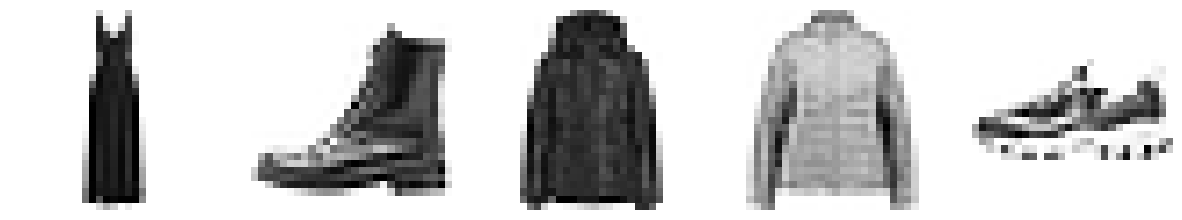

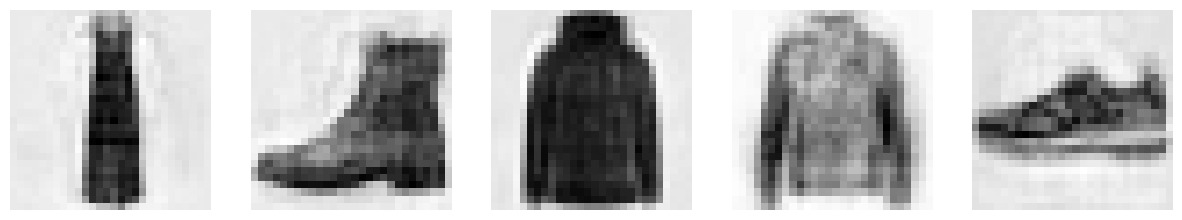

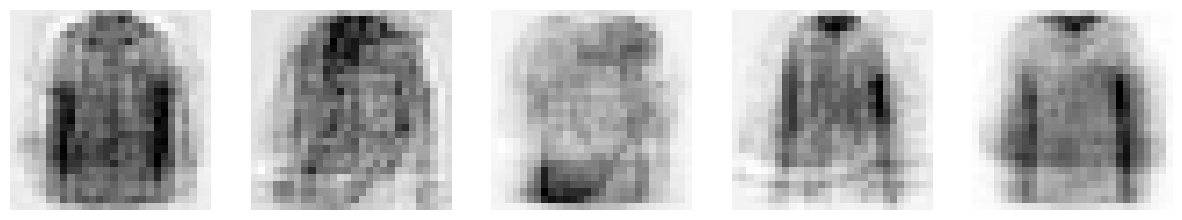

In [32]:
num_samples = 5
mu, sigma = sample_params(num_samples, DISTR = DISTR) 

random_indices = random.sample(range(100), num_samples)
initial = test_ds[random_indices][1]

test_distr_params = vad.dist_params[random_indices]
restored_test = vad(test_distr_params).view(-1, 28, 28)

random_distr_params = torch.cat((mu,sigma),dim=1)
restored_random = vad(random_distr_params).view(-1, 28, 28)

plot_tensors_as_images(initial)
plot_tensors_as_images(restored_test)
plot_tensors_as_images(restored_random)

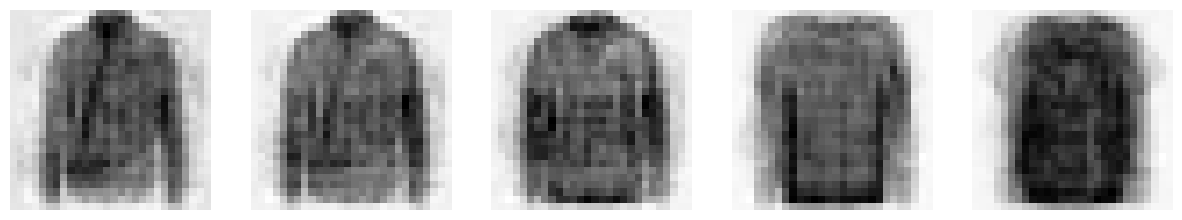

In [20]:
for i in range(200):
    if test_ds.y[i]==0:
        a_indx = i

for i in range(200):
    if test_ds.y[i]==2:
        b_indx = i

a_vec = vad.sample_vectors(vad.dist_params[a_indx:a_indx+1,:])
b_vec = vad.sample_vectors(vad.dist_params[b_indx:b_indx+1,:])

restored = []
for t in range(5):
    lat = a_vec*(t/4)+b_vec*(1-t/4)
    rec = vad.decode(lat)
    restored.append(rec)

stacked = torch.stack(restored, dim=0).view(-1,28,28)
plot_tensors_as_images(stacked)